In [36]:
import numpy, pandas, datetime, importlib, dotenv, os, cobra, pickle

In [2]:
import multiprocessing, multiprocessing.pool
from multiprocessing import Process, Queue

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':30, 'ytick.labelsize':30, 'axes.labelsize':40, 'figure.figsize':(12, 8)})

In [4]:
def growth_coupled_analysis(task):
    
    """
    This function performs the growth-coupled production.
    It takes as input a list as [first_gene_pair_index, second_gene_pair_index, reaction_of_interest, biomass_reaction_label]
    It gives as output a list as [first_gene_pair_index, second_gene_pair_index, growth, min_production, max_production]
    """
    
    i = task[0]
    j = task[1]
    reaction_of_interest = task[2]
    biomass_reaction_label = task[3]
    model = task[4]
    
    with model as model:
                
        # KO
        model.genes[i].knock_out()
        model.genes[j].knock_out()
        solution = model.optimize()
        if solution.status == 'optimal':
            ko_growth = solution.objective_value

            # growth-coupled production
            model.objective = reaction_of_interest
            model.reactions.get_by_id(biomass_reaction_label).lower_bound = ko_growth
            max_production = model.optimize(objective_sense='maximize').objective_value
            min_production = model.optimize(objective_sense='minimize').objective_value
            
            result = [i, j, ko_growth, min_production, max_production]
        else:
            result = [i, j, 0, 0, 0]

    return result

In [5]:
def printt(message):

    print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S \t {}".format(message)))

    return None

# 1. load the model

In [6]:
io_path = '/home/adrian/hub/LVF601M/yeast/yeast-GEM/code/io.py'

Clone just once.

In [7]:
#! git clone https://github.com/SysBioChalmers/yeast-GEM.git

Here is the nightmare of reading the model using their methods.

In [8]:
os.chdir('yeast-GEM')
#! touch .env

# find .env + define paths:
dotenv_path = dotenv.find_dotenv()
REPO_PATH = os.path.dirname(dotenv_path)
MODEL_PATH = f"{REPO_PATH}/model/yeast-GEM.xml"

In [9]:
spec = importlib.util.spec_from_file_location("i_dont_know_what_is_this", io_path)
foo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo)
model = foo.read_yeast_model()

Restricted license - for non-production use only - expires 2023-10-25


# 2. explore the model

In [10]:
working_solver = "cplex" # much faster version of glpk
model.solver = working_solver
model.solver

In [11]:
model.metabolites.get_by_id("s_0681[e]") #s_0681[e] is the id of ethanol in the model

Metabolite identifier,s_0681[e]
Name,ethanol [extracellular]
Memory address,0x07f92f0fcf670
Formula,C2H6O
Compartment,e
In 2 reaction(s),"r_1761, r_1762"


In [12]:
model.reactions.get_by_id('r_1761')

Reaction identifier,r_1761
Name,ethanol exchange
Memory address,0x07f92ef603400
Stoichiometry,s_0681[e] --> ethanol [extracellular] -->
GPR,
Lower bound,0.0
Upper bound,1000.0


In [13]:
model.reactions.get_by_id('r_1762')

Reaction identifier,r_1762
Name,ethanol transport
Memory address,0x07f92ef603700
Stoichiometry,s_0680[c] <=> s_0681[e] ethanol [cytoplasm] <=> ethanol [extracellular]
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [14]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
s_0420[e],r_1654,0.5988,0,0.00%
s_0565[e],r_1714,1,6,100.00%
s_0796[e],r_1832,0.04236,0,0.00%
s_0925[e],r_1861,2.63E-06,0,0.00%
s_1277[e],r_1992,2.25,0,0.00%
s_1324[e],r_2005,0.545,0,0.00%
s_1374[e],r_2020,0.000304,0,0.00%
s_1438[e],r_2049,0.0003325,0,0.00%
s_1468[e],r_2060,0.007203,0,0.00%
s_4200[e],r_4593,0.000108,0,0.00%


In [15]:
wt_solution = model.optimize()
print(wt_solution.objective_value)

0.08374770604149129


In [16]:
number_of_genes = len(model.genes)
print(number_of_genes)

1150


# 2. growth-coupled metabolite production exploration

## 2.1. define metabolite of interest and biomass function label

In [17]:
reaction_of_interest = 'r_1761' # ethanol export
biomass_reaction_label = 'r_2111' # biomass function

## 2.2. run serial

- 1,225 pairs (50 x 50 genes) takes 3 min 8 sec in serial

In [18]:
%%time
results = []
for i in range(len(model.genes[:50])):
    for j in range(len(model.genes[:50])):
        if i < j:
            
            task = [i, j, reaction_of_interest, biomass_reaction_label, model]
            result = growth_coupled_analysis(task)
            results.append(result)         

CPU times: user 3min 10s, sys: 35.7 ms, total: 3min 10s
Wall time: 3min 10s


In [19]:
print(len(results))
df = pandas.DataFrame(results, columns=['i', 'j', 'KO growth', 'min production', 'max production'])
df.head()

1225


,i,j,KO growth,min production,max production
0,0,1,0.012067,1.765582,1.806006
1,0,2,0.012067,1.765582,1.806006
2,0,3,0.012067,1.765582,1.806006
3,0,4,0.012067,1.765582,1.806006
4,0,5,0.012067,1.765582,1.806006


In [20]:
df.sort_values(by=['min production'], ascending=False).head()

,i,j,KO growth,min production,max production
875,23,25,0.012094,1.805569,1.805569
934,25,35,0.012094,1.805569,1.805569
930,25,31,0.012094,1.805569,1.805569
945,25,46,0.012094,1.805569,1.805569
947,25,48,0.012094,1.805569,1.805569


### 2.2.1. plot production envelope

In [21]:
# WT
plotting_wt_biomass = []
wt_production = []

biomass_space = numpy.linspace(0, wt_solution.objective_value, 100)

with model as model:
    model.objective = reaction_of_interest
    for target in biomass_space:
        model.reactions.get_by_id(biomass_reaction_label).bounds = (target, target)
        solution = model.optimize()
        if solution.status == 'optimal':
            plotting_wt_biomass.append(target); wt_production.append(solution.objective_value)

In [22]:
# KO
i=3; j=40

plotting_ko_biomass = []
max_productions = []
min_productions = []

with model as model:
    model.genes[i].knock_out() 
    model.genes[j].knock_out()
    ko_solution = model.optimize()
    
    biomass_space = numpy.linspace(0, ko_solution.objective_value, 100)
    with model as model:
        model.objective = reaction_of_interest
        for target in biomass_space:
            model.reactions.get_by_id(biomass_reaction_label).lower_bound = target
            max_production = model.optimize(objective_sense='maximize').objective_value
            min_production = model.optimize(objective_sense='minimize').objective_value
            plotting_ko_biomass.append(target); max_productions.append(max_production); min_productions.append(min_production)

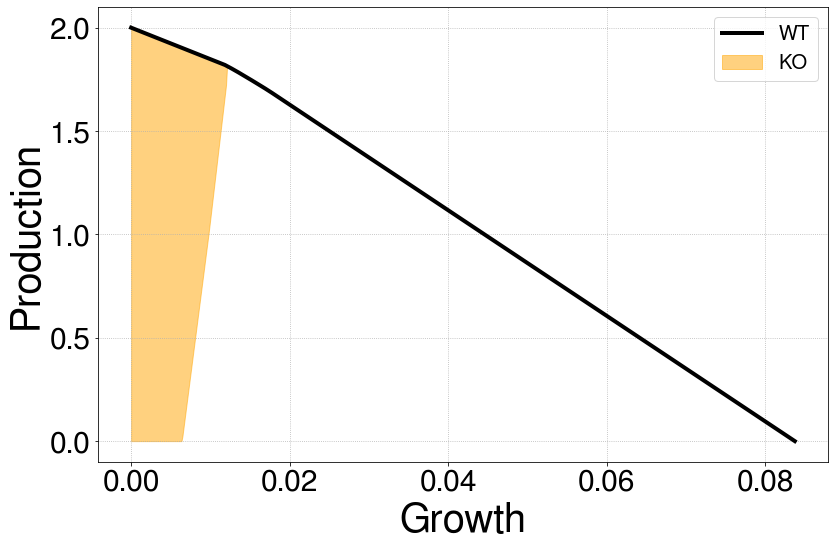

In [23]:
# make figure
matplotlib.pyplot.plot(plotting_wt_biomass, wt_production, '-', color='black', lw=4, label='WT')
matplotlib.pyplot.fill_between(plotting_ko_biomass, min_productions, max_productions, color='orange', alpha=0.5, label='KO')

matplotlib.pyplot.xlabel('Growth')
matplotlib.pyplot.ylabel('Production')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.legend()

matplotlib.pyplot.tight_layout()

## 2.3. run in parallel environment

Using multiprocessing could be difficult because if the function yields an error, it is difficult to track. Consider using testing functions and serial code as in previous section to avoid errors while executing the parallel approach.

In [32]:
number_of_threads = 20

Having 1,150 genes to test implies 660,675 gene-pair evaluations.  

In in a 20 threads environment:  

- 50 x 50 genes implies 1,225 gene pairs which takes 33 sec.
- 100 x 100 genes implies 4,950 gene pairs which takes 1 min 45 sec.
- 450 x 450 genes implies 101,025 gene pairs which takes 35 min.
- all genes implies 660,675 gene pairs which takes xx min.

In [33]:
printt('working with {} genes'.format(number_of_genes))

tasks = []
for i in range(len(model.genes[:450])):
    for j in range(len(model.genes[:450])):
        if i < j:
            task = [i, j, reaction_of_interest, biomass_reaction_label, model]
            tasks.append(task)
printt('working with {} gene pairs'.format(len(tasks)))

2022-03-29 19:29:39 	 working with 1150 genes
2022-03-29 19:29:39 	 working with 101025 gene pairs


In [34]:
%%time
printt('entering a parallel world of {} threads'.format(number_of_threads))
hydra = multiprocessing.pool.Pool(number_of_threads)
hydra_output = hydra.map(growth_coupled_analysis, tasks)
hydra.close()
printt('completed {} tasks'.format(len(hydra_output)))

2022-03-29 19:29:39 	 entering a parallel world of 20 threads


/home/adrian/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/adrian/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/adrian/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/adrian/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/adrian/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/adrian/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"

2022-03-29 20:05:07 	 completed 101025 tasks
CPU times: user 9.76 s, sys: 472 ms, total: 10.2 s
Wall time: 35min 28s


In [35]:
df = pandas.DataFrame(hydra_output, columns=['i', 'j', 'KO growth', 'min production', 'max production'])
df.sort_values(by=['min production'], ascending=False)

,i,j,KO growth,min production,max production
366,0,367,0.011881,1.817702,1.817702e+00
3039,6,367,0.011881,1.817699,1.817700e+00
11266,25,367,0.011885,1.816947,1.816947e+00
78787,238,367,0.011885,1.816947,1.816947e+00
96937,359,367,0.011885,1.816947,1.816947e+00
...,...,...,...,...,...
35002,86,130,0.083679,0.000000,-3.410605e-13
35001,86,129,0.000000,0.000000,2.000000e+00
35000,86,128,0.083748,0.000000,4.206413e-12
34999,86,127,0.000000,0.000000,2.000000e+00


# 3. store dataframe

In [37]:
printt('store double KO information as a dataframe')

f = open('doubleKO.pickle','wb')
pickle.dump(df, f)
f.close()

2022-03-29 20:06:17 	 store double KO information as a dataframe
